# Qiskit Demo

Author: Brandon Kamaka <br>
Date: 2019 June 04<br>
Original Source: [IBM Index San Francisco](https://www.youtube.com/watch?v=LSA3pYZtRGg) <br>
Qiskit Version: 0.10.3 <br>
Available [on Github](https://github.com/ParanoydAndroid/Qiskit_Demo.git)


## Section 1: Setting up your IBM Account
###

In [1]:
%%capture
from qiskit import IBMQ
# On your first run, and only your first run, you'll have to save your account
# API_TOKEN = 'INSERT YOUR IBM API TOKEN HERE'
# 
# # This is optional for the default IBMQ configuration, but will be required for our hub accounts
# url = 'https://quantumexperience.ng.bluemix.net/api'
# 
# IBMQ.save_account(API_TOKEN, url=url)

# On subsequent runs, you just have to load your previously saved account(s)
IBMQ.load_accounts()

In [1]:
# You can also see various account details

print(IBMQ.stored_accounts())
print(IBMQ.active_accounts())
# IBMQ.enable_account()
# IBMQ.disable_accounts()

## Section 2: Setting up the Bernstein-Vazirani Circuit

In [4]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister

# Create our initial registers.  The name parameter is used by the circuit drawer
q = QuantumRegister(4, name='q')
tmp = QuantumRegister(1, name='t')
meas = ClassicalRegister(4, name='m')

In [5]:
# Create the Oracle
# We'll choose the secret bitstring 14 == 1110

oracle = QuantumCircuit(q, tmp, meas, name='Oracle')
s = 14

for i in range(len(q)):
    if s & (1 << i):
        oracle.cx(q[i], tmp[0])


In [6]:
print(oracle.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
qreg t[1];
creg m[4];
cx q[1],t[0];
cx q[2],t[0];
cx q[3],t[0];



In [7]:
# Now we create the Bernstein-Vazirani circuit
bv = QuantumCircuit(q, tmp, meas)
bv.x(tmp[0])

# If we don't provide an index, then the h applies to the entire register
bv.h(q)
bv.h(tmp)

# We'll come back to this
bv += oracle

# Second layer of hadamards
bv.h(q)
bv.h(tmp)

bv.measure(q, meas)

In [8]:
print(bv.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
qreg t[1];
creg m[4];
x t[0];
h q[0];
h q[1];
h q[2];
h q[3];
h t[0];
cx q[1],t[0];
cx q[2],t[0];
cx q[3],t[0];
h q[0];
h q[1];
h q[2];
h q[3];
h t[0];
measure q[0] -> m[0];
measure q[1] -> m[1];
measure q[2] -> m[2];
measure q[3] -> m[3];



## Section 3: Basic Visualization

In [9]:
# Show text circuit.  Same as bv.draw(output='text')
bv.draw()

<pre style="word-wrap: normal;white-space: pre;line-height: 15px;">        ┌───┐┌───┐     ┌─┐                             
q_0: |0>┤ H ├┤ H ├─────┤M├─────────────────────────────
        ├───┤└───┘     └╥┘┌───┐     ┌─┐                
q_1: |0>┤ H ├───────■───╫─┤ H ├─────┤M├────────────────
        ├───┤       │   ║ └───┘     └╥┘┌───┐┌─┐        
q_2: |0>┤ H ├───────┼───╫───■────────╫─┤ H ├┤M├────────
        ├───┤       │   ║   │        ║ └───┘└╥┘┌───┐┌─┐
q_3: |0>┤ H ├───────┼───╫───┼────■───╫───────╫─┤ H ├┤M├
        ├───┤┌───┐┌─┴─┐ ║ ┌─┴─┐┌─┴─┐ ║       ║ ├───┤└╥┘
t_0: |0>┤ X ├┤ H ├┤ X ├─╫─┤ X ├┤ X ├─╫───────╫─┤ H ├─╫─
        └───┘└───┘└───┘ ║ └───┘└───┘ ║       ║ └───┘ ║ 
 m_0: 0 ════════════════╩════════════╬═══════╬═══════╬═
                                     ║       ║       ║ 
 m_1: 0 ═════════════════════════════╩═══════╬═══════╬═
                                             ║       ║ 
 m_2: 0 ═════════════════════════════════════╩═══════╬═
                                                     ║ 
 m_3: 0 ═════════════════════════════════════════════╩═
                                                       </pre>

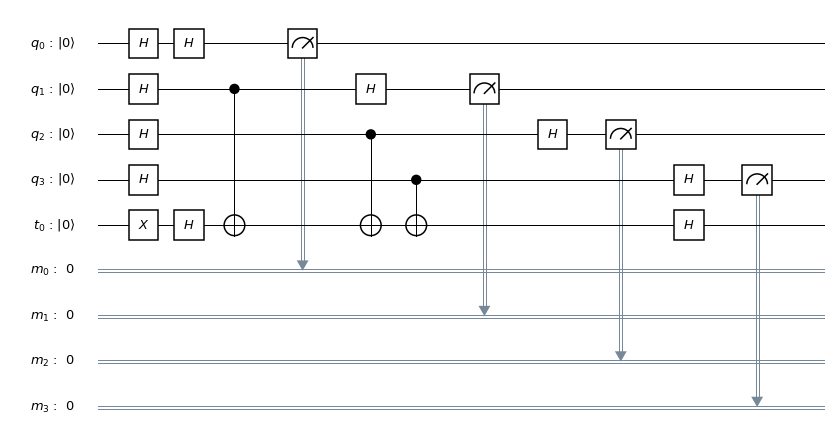

In [10]:
# Show matplotlib figure
%matplotlib inline

bv.draw(output='mpl')

# Or, without magic function

# fig = bv.draw(output='mpl')
# fig.show()

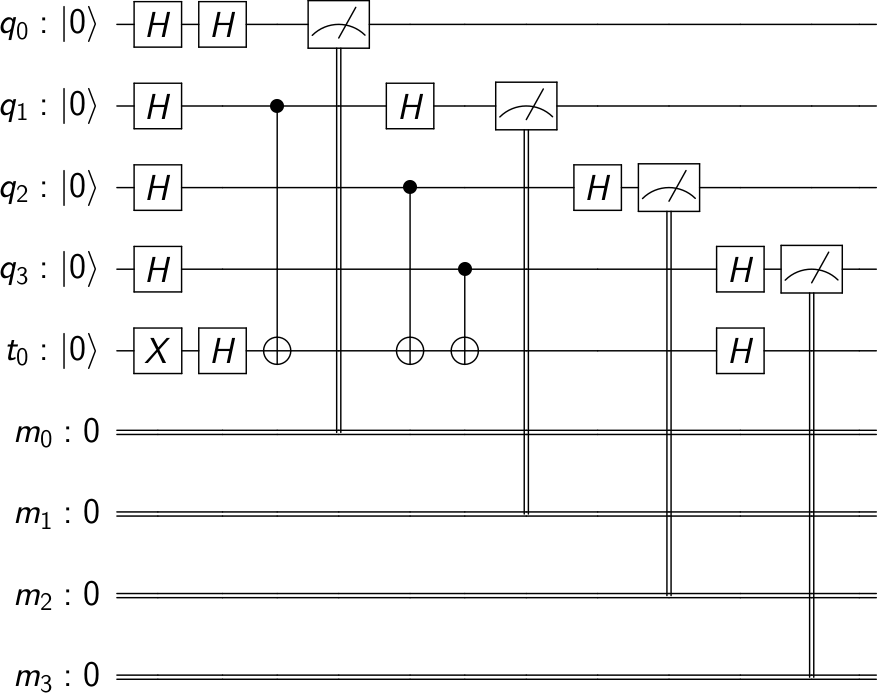

In [11]:
# Show Latex figure
bv.draw(output='latex')

In [17]:
# Show latex figure source
# bv.draw(output='latex_source')

### Section 3a: Cleaning up our Circuit

In [12]:
# Now let's clean up our circuit by using barriers
circ = QuantumCircuit(q, tmp, meas)

circ.x(tmp[0])
circ.barrier()

circ.h(q)
circ.h(tmp)
circ.barrier()

circ += oracle
circ.barrier()

circ.h(q)
circ.h(tmp)
circ.barrier()

circ.measure(q, meas)

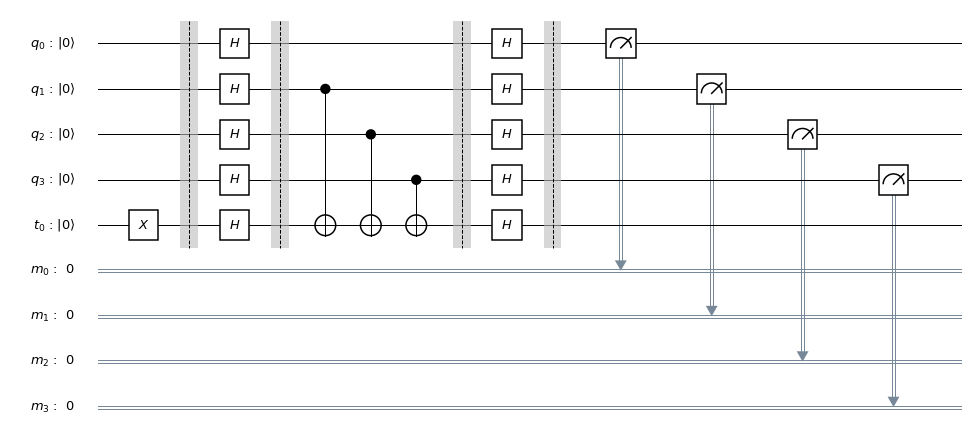

In [19]:
circ.draw(output='mpl')

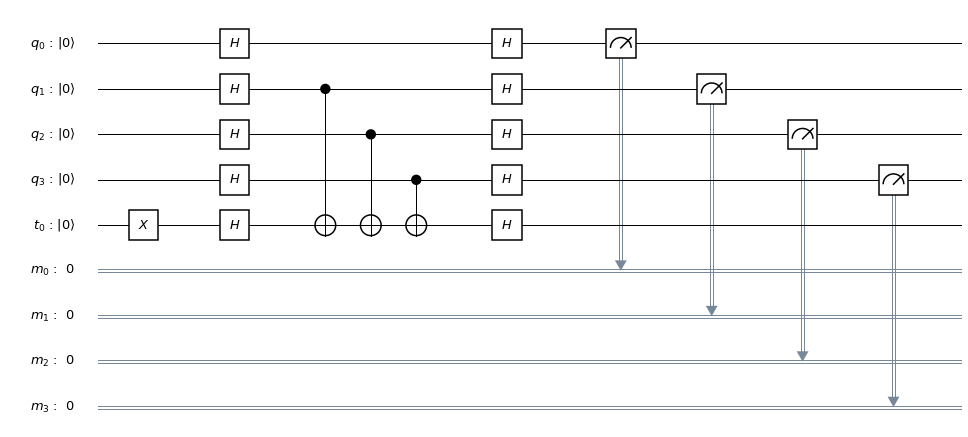

In [23]:
# Even better cleanup
circ.draw(output='mpl', plot_barriers=False, filename='BV-Circ')

## Section 5: Integrating Circuits

In [33]:
# Now let's go back to how our circuit is defined.  
# Maybe we want to improve our abstraction

abstract_circ = QuantumCircuit(q, tmp, meas)
abstract_circ.x(tmp[0])
abstract_circ.barrier()

abstract_circ.h(q)
abstract_circ.h(tmp)
abstract_circ.barrier()

# Instead of showing our individual gates, we just want an abstract gate
gate_oracle = oracle.to_instruction()

# Note that to append, we have to create lists from our registers
abstract_circ.append(gate_oracle,
                     [q[0], q[1], q[2], q[3], tmp[0]],
                     list(meas))
abstract_circ.barrier()

abstract_circ.h(q)
abstract_circ.h(tmp)
abstract_circ.barrier()

abstract_circ.measure(q, meas)


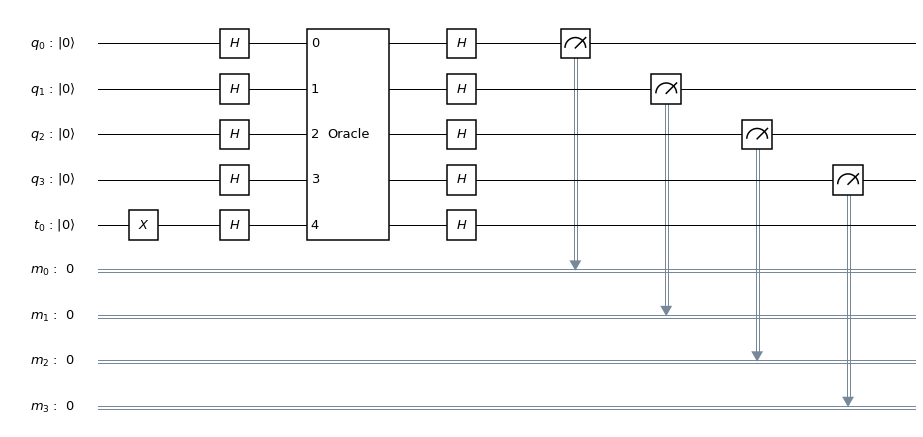

In [34]:
abstract_circ.draw(output='mpl', plot_barriers=False)

In [35]:
# We can even import our own (or a shared) circuit file!
import kamaka

abstract_circ.append(kamaka.flubulator(), [q[1], q[3]])

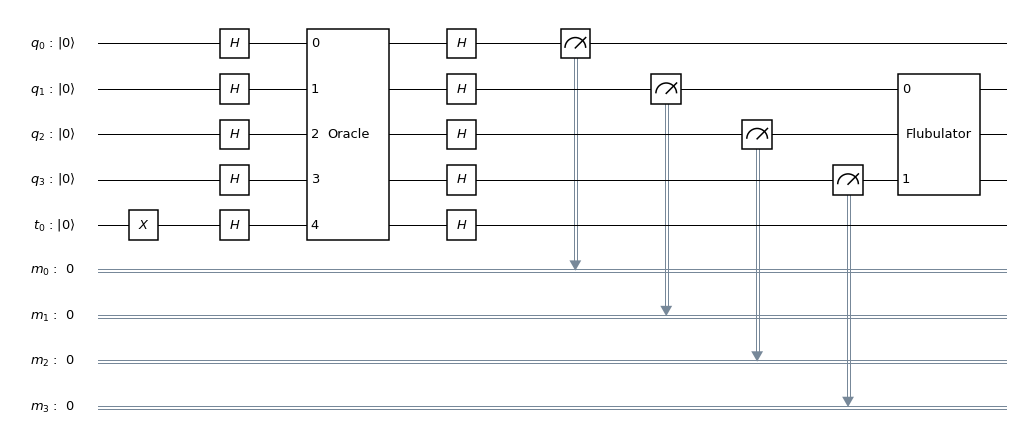

In [36]:
abstract_circ.draw(output='mpl', plot_barriers=False)

In [45]:
# # Finally, we can recover our original view by way of "decompose"
# 
# decomposed_circ = abstract_circ.decompose()
# fig4 = decomposed_circ.draw(output='mpl', plot_barriers=False)
# fig4.show()

## Executing Jobs

In [13]:
# Now we run our circuit
# First, we need to know our backends
from qiskit import Aer, BasicAer, execute  # Local backends, sim only

# We've already imported the IBMQ module that gives access to remote backends -- both real and sims. 
# Now let's look at them
for idx, be in enumerate(.backends()):
    print(f'IBMQ backend {idx}: {be}')
IBMQ
for idx, be in enumerate(Aer.backends()):
    print(f'Aer (sim) backend {idx}: {be}')
    
for idx, be in enumerate(BasicAer.backends()):
    print(f'Aer (sim) backend {idx}: {be}')

# We select a backend
backend = BasicAer.get_backend(name='qasm_simulator')

IBMQ backend 0: ibmqx4
IBMQ backend 1: ibmqx2
IBMQ backend 2: ibmq_16_melbourne
IBMQ backend 3: ibmq_qasm_simulator
Aer (sim) backend 0: qasm_simulator
Aer (sim) backend 1: statevector_simulator
Aer (sim) backend 2: unitary_simulator
Aer (sim) backend 0: qasm_simulator
Aer (sim) backend 1: statevector_simulator
Aer (sim) backend 2: unitary_simulator


In [14]:
from qiskit.tools.monitor import job_monitor

# Now we execute, **asynchronously^^
job = execute(circ, backend)
result = job.result()
counts = result.get_counts(circ)

print(counts)

{'1110': 1024}


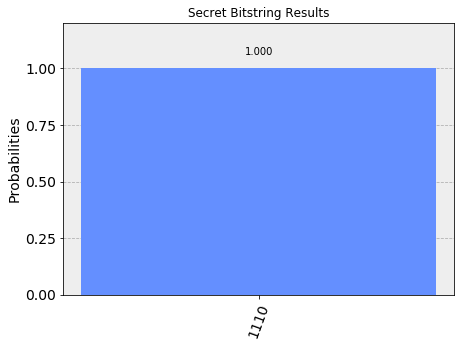

In [35]:
from qiskit.tools.visualization import plot_histogram

plot_histogram(counts, title='Secret Bitstring Results')

In [37]:
%%capture

# For jobs run on real machines, let's talk about how to handle queues
real_backend = IBMQ.get_backend('ibmqx2')
shots = 512  # Number of times to re-run the experiment
max_credits = 5  # Maximum cost you're willing to incur
job = execute(circ, real_backend, shots=shots, max_credits=max_credits)

job_monitor(job)


jobID = job.job_id()
print(f'Job ID: {jobID}')

new_job = real_backend.retrieve_job(jobID)



Job Status: job is being initialized

Job Status: job is actively running 

Job Status: job has successfully run


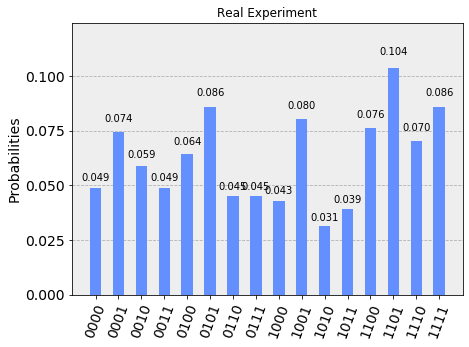

In [38]:
from qiskit.tools.visualization import plot_histogram
result = job.result()
counts = result.get_counts()
plot_histogram(counts, title='Real Experiment')

In [50]:
# That's a bit boring though.  Lets do a bell state circuit

qr = QuantumRegister(2)
msr = ClassicalRegister(2)

bs = QuantumCircuit(qr, msr)
bs.h(qr[0])
bs.cx(qr[0], qr[1])
bs.measure(qr, msr)

{'11': 516, '00': 508}


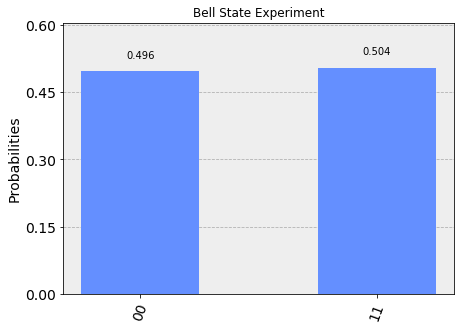

In [42]:
job = execute(bs, backend)
job.status()

job_monitor(job)
result = job.result()
counts = result.get_counts(bs)

print(counts)
plot_histogram(counts, title='Bell State Experiment')

## Section 6: Using Other Sims

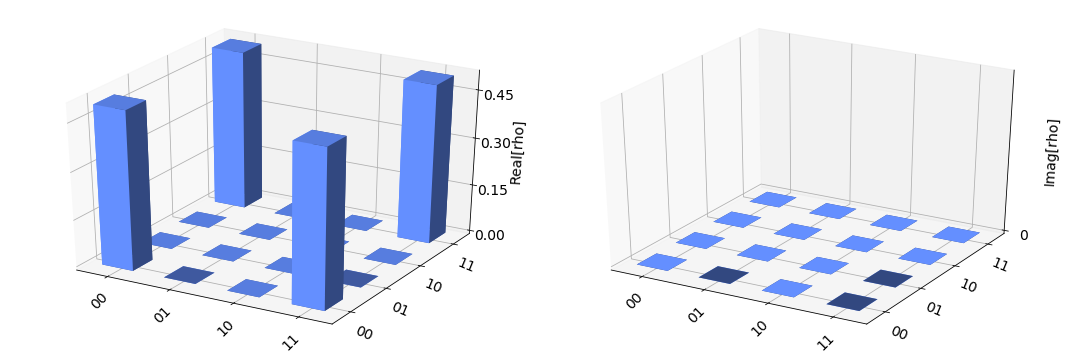

In [55]:
# Getting state vectors
from qiskit.tools.visualization import plot_state_city, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
new_backend = Aer.get_backend('statevector_simulator')
result = execute(bs, new_backend).result()
vec = result.get_statevector(bs)
plot_state_city(vec)

In [58]:
# Getting Matrices
# Cannot have a measurement

newest_backend = Aer.get_backend('unitary_simulator')
job = execute(bs, newest_backend)
result = job.result()

matrix = result.get_unitary(bs)

print('Resulting Unitary Matrix:\n')
print(matrix)


Resulting Unitary Matrix:

[[ 0.70710678+0.j  0.70710678+0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.70710678+0.j -0.70710678+0.j]
 [ 0.        +0.j  0.        +0.j  0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j  0.        +0.j  0.        +0.j]]


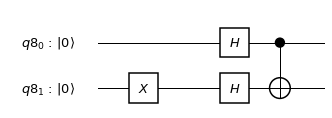

In [32]:
q2 = QuantumRegister(2)
qc2 = QuantumCircuit(q2)

qc2.x(q2[1])
qc2.barrier()
qc2.h(q2)
qc2.cx(q2[0], q2[1])

qc2.draw(output='mpl', filename='phase_kickback', plot_barriers=False)

In [39]:
backend.details()

AttributeError: 'QasmSimulatorPy' object has no attribute 'details'